## This notebook for data preprocessing here we will do the following steps:
1. Load the data.
2. split the data.
3. do some EDA.
4. cleanig and preprocessing.

In [24]:
!pip install pyarabic
!pip install emoji
!pip install farasapy




## Importing the required libraries

In [25]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import emoji

from farasa.stemmer import FarasaStemmer
from nltk.corpus import stopwords
import pyarabic.araby as araby

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_colwidth', 100000)


In [58]:
from sklearn.linear_model import LogisticRegression


In [62]:
from sklearn.pipeline import Pipeline


In [67]:
from sklearn.metrics import f1_score


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loding dataset

In [27]:
data = pd.read_csv("/content/drive/MyDrive/NLP/Final Task/Data/data.csv")

In [ ]:
data.columns

Index(['id', 'text', 'dialect'], dtype='object')

In [ ]:
data.sample(5)

,id,text,dialect
15579,745951303105396736,@mehp89 😰😩🙈🙊 معليش صيام مفيش تركيز يا دكتور,LY
121297,929102795483041792,@Ab_Fii خلص روح العب بشي نعجه احط,LB
103300,1162482949528403968,و كما قال المثل الانجليزي .... you can't polis...,EG
117493,1128528003997343616,@Safaa16111Safaa صحيح بس بدو تغيير بوجيات ما اكتر,LB
70955,1126574974465191936,@hannaemil1 انا مش بشوف اى ايفينت يا حنا\nعامة...,EG


## Data splitting

In [28]:
x = data.drop(['dialect','id'],axis=1)
labels = data['dialect']
x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=.2, stratify=labels, random_state=42)

## EDA on training data

- check NaNs

In [ ]:
if x_train.isna().values.any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values in the DataFrame.")

No missing values in the DataFrame.


In [ ]:
if x_train.duplicated().sum() == 0:
    print("No duplicates in the DataFrame.")
else:
    print("There are duplicates in the DataFrame.")

No duplicates in the DataFrame.


- showing a representative sample of data texts to find out required preprocessing steps

In [ ]:
x_train.sample(10)

,text
17679,@AbeerMjnony ههههههه ويحتاج اندير بحث .من اللي ما يعرفش بس الموضوع انه ايطاليا فريق البنات .واستغربتك تكرهيهم ..فقط
62039,هترتاحوا في الجامعه يا جماعه و هتذاكروا بمزاجكوا و انتوا مشغلين اغاني و مش مضغوطين ولا قرفانين ولا خايفين و قاعدين في النادي او كافيه براحتكوا و اهلكوا مش هيعترضوا و هتتبسطوا جداً من كل حاجه و متسمعوش لحد . السر في الصحاب اللي تعملوا معاهم كده بس مش اكتر♥️♥️
104977,@rogina91 كان معايا مهندس زميل زمان مره اتناقشنا في موضوع المخدرات قالي الحشيش مش حرام ولكن البيره حرام قلتله ليه قالي البيره والخمره مصنعه وبتسكر فحرام ولكن الحشيش نبات زرع خلقه ربنا فمش حرام
100225,#حياتي_بتحلو_لما\nامي تدعيلي وانا نازل الشغل\nدعوة الأم بتفتح ابواب متقفلة
142028,@hashomy_95 اي والله علي اليمين جاي فاقد اي شيء
130750,@mmki123 يخرب عقلك من وين ناكشها 🤣
71780,"دواء للسرطان أسمه جلافيك.. Glivec 100\n100mg\nسعر العلبه 11الف جنيه \nموجود مجانا ""اللي معاه الروشته \nومعاه ما يثبت انو مريض سرطان""\nيتصل علي \n01270914171\n01097665063\nبلاش رتويت خد copy عشان يظهر لأكبر عدد\nاللهم أشفي كل مريض♥\n\n#منقول"
66093,@Nuha_mansour ربنا يخليلنا بنات الدفعه والله بيتعبو 😂😂
107066,كتبت هالتويت ومش فايقة اني كتبتو ع فكرة\nولهلأ ما نمت
35456,@saaddenali علي اليمين الغرابه مايريدولنا وجه ولاهم حاسبينا معاهم في هالوطن...


- check dataset balancing

In [ ]:
class_counts = y_train.value_counts()
print("Class distribution:")
print(class_counts)

Class distribution:
dialect
EG    46109
LY    29199
LB    22094
SD    11547
MA     9231
Name: count, dtype: int64


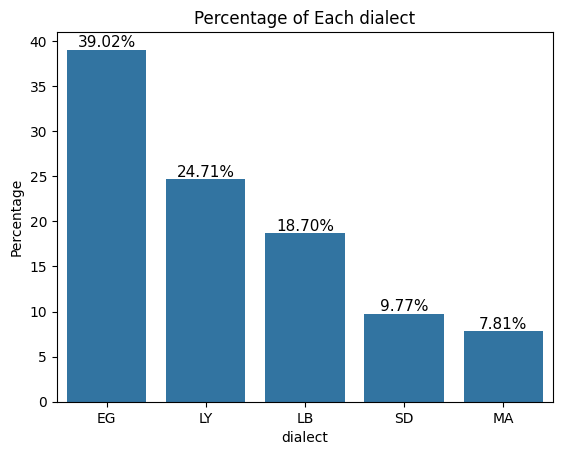

In [ ]:
rating_counts = y_train.value_counts(normalize=True) * 100

# Plot
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.xlabel('dialect')
plt.ylabel('Percentage')
plt.title('Percentage of Each dialect')

# Adding percentage text above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Dataset is imbalanced
- We will use f1 score as a metric to evaluate the model, as it is more robust to imbalanced datasets than accuracy.<br>
- We can also perform downsampling to balance the dataset but we will delay this step for now.<br>
- `Note:` Maybe we shouldn't change the data balance and work with the imbalanced data because it's the data nature to be imbalanced because `EG` is the most spoking Arabic dialect because of high population numbers.<br>

## Cleaning and Preprocessing

In [30]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Initialize Farasa components
farasa_stemmer = FarasaStemmer(interactive=True)

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.arabic_stop_words = set(stopwords.words('arabic'))
        self.tokenizer = Tokenizer()
        self.symbols_pattern = re.compile(r'("|\|\|\||!|!!!|`|\.{3}|_)')
        self.arabic_punctuation_pattern = re.compile(r'[،؟؛٪«»…ـ‘’“”]')
        self.general_punctuation_pattern = re.compile(r'[^\w\s]')
        self.digits_pattern = re.compile(r'\d+')
        self.username_pattern = re.compile(r'@\w+')
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.single_char_pattern = re.compile(r'\b\w{1,2}\b')

    def preprocess_sentence(self, sentence):
        # Remove diacritics
        sentence = araby.strip_tashkeel(sentence)
        # Normalize hamzas
        sentence = araby.normalize_hamza(sentence)
        # Remove URLs
        sentence = self.url_pattern.sub('', sentence)
        # Remove usernames
        sentence = self.username_pattern.sub('', sentence)
        # Remove emojis
        sentence = emoji.replace_emoji(sentence, replace='')
        # Remove specific symbols
        sentence = self.symbols_pattern.sub('', sentence)
        # Remove non-word and non-digit characters
        sentence = re.sub(r'[^\w\d\s]+', '', sentence)
        # Remove punctuation and numbers
        sentence = self.arabic_punctuation_pattern.sub('', sentence)
        sentence = self.general_punctuation_pattern.sub('', sentence)
        sentence = self.digits_pattern.sub('', sentence)
        # Split text into words
        words = araby.tokenize(sentence)
        # Apply stemming
        stemmed_words = [farasa_stemmer.stem(word) for word in words if farasa_stemmer.stem(word) is not None]
        # Remove stop words
        filtered_words = [word for word in stemmed_words if word not in self.arabic_stop_words]
        return ' '.join(filtered_words)

    def preprocess_dataframe_column(self, data):
        return data.apply(self.preprocess_sentence)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transformed_X = self.preprocess_dataframe_column(X['text'])
        transformed_X = np.array(transformed_X).reshape(-1, 1)
        return transformed_X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[2024-05-24 08:36:35,589 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [31]:
trans = CustomTransformer()
d_x_train  = trans.fit_transform(x_train)


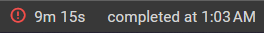

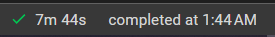

In [32]:
y_train = np.array(y_train).reshape(-1,1)

In [37]:
d_y_train_df = pd.DataFrame(y_train, columns=['type'])


In [38]:
print("Unique tags in corpus:", d_y_train_df['type'].nunique())

Unique tags in corpus: 5


In [39]:
transformed_X_test= trans.transform(x_test)
transformed_X_test = np.array(transformed_X_test).reshape(-1,1)
print(transformed_X_test.shape)

(29545, 1)


In [41]:
d_x_test_df = pd.DataFrame(transformed_X_test,columns=['text'])


## converting to numerical representation

In [45]:
d_x_train_df = pd.DataFrame(d_x_train , columns = ['text'])

In [47]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(d_x_train_df['text'])
sequences = tokenizer.texts_to_sequences(d_x_train_df['text'])

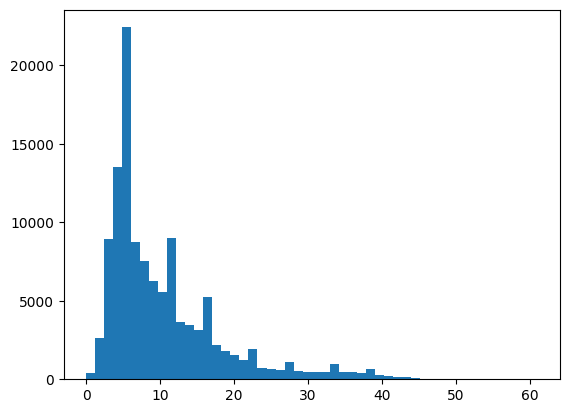

In [110]:
plt.hist([len(s) for s in sequences], bins=50)
plt.show()

`Note:`We will chose tow `max_len` and save them to train our model.

In [103]:
max_len = 40
max_len2 = 26
# number of unique words
vocab_size =len(tokenizer.word_index)+1
print("Unique tags in corpus:",vocab_size )

Unique tags in corpus: 116965


## Padding

In [104]:
padded_sequences_train = pad_sequences(sequences, maxlen= max_len, padding='post' ,truncating='post')
padded_sequences_train2 = pad_sequences(sequences, maxlen= max_len2, padding='post' ,truncating='post')


### Tokenizer and padding on test

In [105]:
# Convert test text to sequences of integers using the fitted tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test['text'])

padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len, padding='post',truncating='post' )
padded_sequences_test2 = pad_sequences(sequences_test, maxlen=max_len2, padding='post',truncating='post' )


In [106]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
print("class labels:", label_encoder.classes_ )
print("encoded values:", np.unique(y_train_encoded))

class labels: ['EG' 'LB' 'LY' 'MA' 'SD']
encoded values: [0 1 2 3 4]


In [96]:
padded_sequences_train

array([[    2,   320,    87, ...,     0,     0,     0],
       [  254, 14452,   355, ...,     0,     0,     0],
       [11097,  1731,    33, ...,     0,     0,     0],
       ...,
       [   55,  1722, 10112, ...,     0,     0,     0],
       [    1,     5,   400, ...,     0,     0,     0],
       [  186,     4,  3466, ...,     0,     0,     0]], dtype=int32)

In [97]:
y_train_encoded

array([2, 2, 0, ..., 2, 0, 0])

In [98]:
model = LogisticRegression()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('model', model),
])
# Now you can use the pipeline for training and prediction
pipeline.fit(padded_sequences_train,y_train_encoded)
pred = pipeline.predict(padded_sequences_test)
pred

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0])

#### Evaluation

**Evaluation metric:**
macro f1 score

Macro F1 score is a useful metric in scenarios where you want to evaluate the overall performance of a multi-class classification model, **particularly when the classes are imbalanced**

![Calculation](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/639c3d934e82c1195cdf3c60_macro-f1.webp)

In [99]:
f1_score(y_test_encoded, pred, average='macro')

0.1122613946240748

In [108]:
padded_sequences_train2.shape , y_train_encoded.shape , y_test_encoded.shape , padded_sequences_test2.shape


((118180, 26), (118180,), (29545,), (29545, 26))

In [109]:
padded_sequences_train.shape , y_train_encoded.shape , y_test_encoded.shape , padded_sequences_test.shape

((118180, 40), (118180,), (29545,), (29545, 40))

In [101]:
train_df = pd.DataFrame({
    'X_train': list(padded_sequences_train),
    'y_train': y_train_encoded
})


test_df = pd.DataFrame({
    'X_test': list(padded_sequences_test),
    'y_test': y_test_encoded
})


train_df2 = pd.DataFrame({
    'X_train': list(padded_sequences_train2),
    'y_train': y_train_encoded
})


test_df2 = pd.DataFrame({
    'X_test': list(padded_sequences_test2),
    'y_test': y_test_encoded
})

# Combine the train and test DataFrames
# combined_df = pd.concat([train_df, test_df], axis=1)

# Save to CSV
train_df.to_csv('train_data_40.csv', index=False)
test_df.to_csv('test_data_40.csv', index=False)

train_df2.to_csv('train_data_40.csv', index=False)
test_df2.to_csv('test_data_40.csv', index=False)



Now we are ready to train our model on `Model_Training` notebook .

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(d_x_train['text'])
sequences = tokenizer.texts_to_sequences(d_x_train['text'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

In [ ]:
model = Sequential([
    Embedding(input_dim=116958, output_dim=128, input_length=40),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(5, activation='sigmoid')
])

In [ ]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', CustomTransformer()),
    ('tokenizing', TokenizerTransformer()),
    ('model', model)
])